In [1]:
import numpy as np
import pandas as pd
import os
import time
import json
import gc
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 第一步，我们先把json格式展开

In [ ]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
train = load_df('/users/lichanghao/data/R/train.csv')
gc.collect()

In [ ]:
train.to_hdf('/users/lichanghao/tempfile/train.h5','train')

In [2]:
train = pd.read_hdf('/users/lichanghao/tempfile/train.h5','train')

In [3]:
train.head(3)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


### totals_transactionRevenue

首先呢，我们先看看我们要预测的transactionRevenue 大概是什么样，

In [4]:
train['totals_transactionRevenue'] = train.totals_transactionRevenue.astype('float')

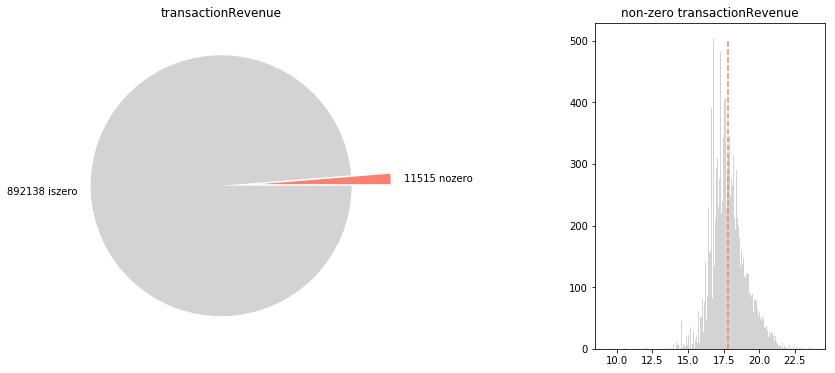

In [5]:
def plotRevence():
    idx = train.totals_transactionRevenue.notnull()
    nozero = sum(idx)
    iszero = train.shape[0] - nozero
    plt.figure(figsize=[14,6])
    plt.subplot(1,2,1)
    plt.pie([nozero,iszero],
            labels=[f'{nozero} nozero',f'{iszero} iszero'],
            radius=1,
            colors=['salmon','lightgray'], 
            explode=[0.3,0])
    plt.title('transactionRevenue')

    plt.subplot(1,3,3)
    revenue = np.log1p(train[idx].totals_transactionRevenue.astype('float')+1)
    plt.hist(revenue, 
             bins=200, 
             color='lightgray')
    plt.plot([np.average(revenue),np.average(revenue)],[0,500],c='salmon',linestyle='--')
    plt.title('non-zero transactionRevenue')
    plt.show()
    return None


plotRevence()

In [6]:
train['target'] = np.log1p(train.totals_transactionRevenue.fillna(0,inplace=False))

我们可以看到，可以说20/80法则发挥着决定性的作用，绝大多数的点击量都是没有成交的，只有大概百分之一的进入是会成交的，而在成交的金额上，在经过ln之后基本符合正态分布，这是个不错的开始。

### channelGrouping 

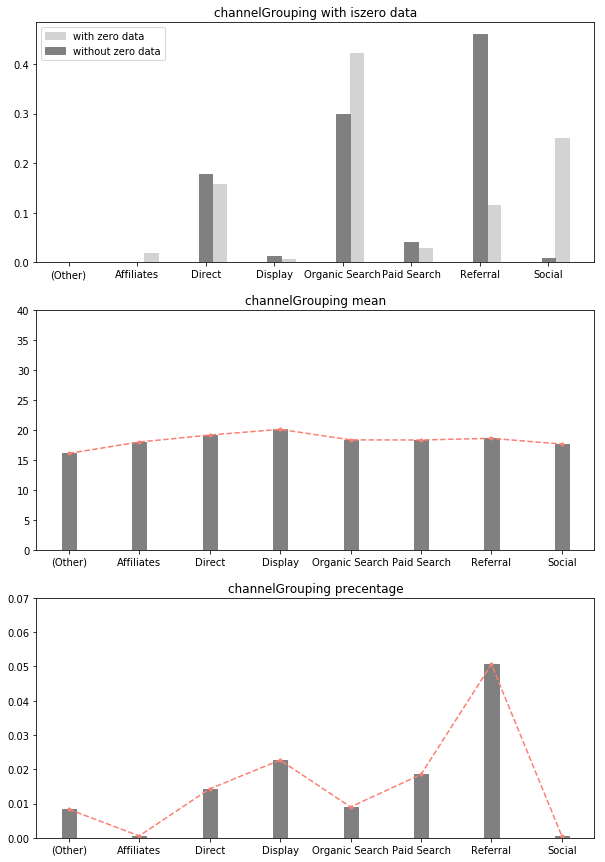

In [7]:
def plotchannel():
    channel = train.channelGrouping.value_counts(dropna=True,normalize=True).sort_index()
    idx = train.totals_transactionRevenue.notnull()
    channel2 = train[idx].channelGrouping.value_counts(dropna=True,normalize=True).sort_index()
    channelmean = train.groupby('channelGrouping').mean().totals_transactionRevenue
    channelpercentage = train[idx].channelGrouping.value_counts(dropna=True,normalize=False)/ train.channelGrouping.value_counts(dropna=True,normalize=False)

    plt.figure(figsize=[10,15])
    plt.subplot(3,1,1)
    plt.bar(np.arange(channel.shape[0])+1,
            channel.values,
            width=np.ones(8)*0.2,
            facecolor='lightgray',
            edgecolor='lightgray',
            tick_label=channel.index.values,
            label='with zero data')
    plt.bar(np.arange(channel2.shape[0])+0.8,
            channel2.values,
            width=np.ones(8)*0.2,
            facecolor='gray',
            edgecolor='gray',
            tick_label=channel.index.values,
            label='without zero data')
    plt.title('channelGrouping with iszero data')
    plt.legend()

    plt.subplot(3,1,2)
    plt.bar(np.arange(channel2.shape[0])+1,
            np.log1p(channelmean.values+1),
            facecolor='gray',
            width=np.ones(8)*0.2,
            edgecolor='gray',
            tick_label=channelmean.index.values)
    plt.plot(np.arange(channel2.shape[0])+1,np.log1p(channelmean.values+1),'.--',c='salmon')
    plt.title('channelGrouping mean')
    plt.ylim([0,40])

    plt.subplot(3,1,3)
    plt.bar(np.arange(channelpercentage.shape[0])+1,
            channelpercentage.values,
            facecolor='gray',
            width=np.ones(8)*0.2,
            edgecolor='gray',
            tick_label=channelpercentage.index.values)
    plt.plot(np.arange(channel2.shape[0])+1,channelpercentage.values,'.--',c='salmon')
    plt.title('channelGrouping precentage')
    plt.ylim([0,0.07])
    plt.show()
    return None

plotchannel()

第一类：市场投放活动（Campaigns）
　　这一类比较常见的是付费关键词即Adwords，如果是Adwords，你不用加码，GA也能非常好的识别出来。当然如果你给自己的某个外部投放加上码，GA也会认为它是一个投放活动。投放活动在GA所有流量来源里，优先级别是最高的。

第二类：自然搜索（Organic）
　　这个大家很理解，就是Google和Baidu等自然搜索引入的流量。它对于GA来说，优先级别与Adwords是一样的。

第三类：推介网站（Referral）
　　这一渠道的流量主要是指从其他网站点过来的链接，比如友情链接等，这类来源通常是免费的。这一来源的优先级别低于市场投放活动和自然搜索。

第四类：直接输入（Direct）
　　直接输入包括几个方面，一个是直接在地址里输入网站，第二个是利用收藏夹与标签，第三个是从桌面软件，比如从QQ，MSN等软件点过来的链接，第四个是如果无法判别流量来源的话，也会归入直接输入。这个来源的优先级是最低的，大家抢的都是这个流量。

结论： 由上图我们可以看出，social项拥有很高的浏览量，但是成交比很低，很多人都只是单纯的点进来看看，并没有买任何东西。social项很可能指的是网站在社交媒体上投放广告。反之Referral项虽然没有太多的浏览量，但是成交比却很高。 当然，关键词广告自然搜索所占浏览量很大，但是成交比并不大。

### 我觉得seesionId 应该就是fullvisitId 与 visitId 的结合，验证以下，如果是的话，我们就可以把 这个features去掉了。

In [8]:
print('fullvisitId sess diff:',sum(train.sessionId.str.split('_',expand=True)[0] != train.fullVisitorId))
print('visitId sess diff:',sum(train.sessionId.str.split('_',expand=True)[1] != train.visitId.astype('str')))

fullvisitId sess diff: 0
visitId sess diff: 0


In [9]:
train.drop(['sessionId'],axis=1,inplace=True)

### 接下来，把时间date转化为时间格式

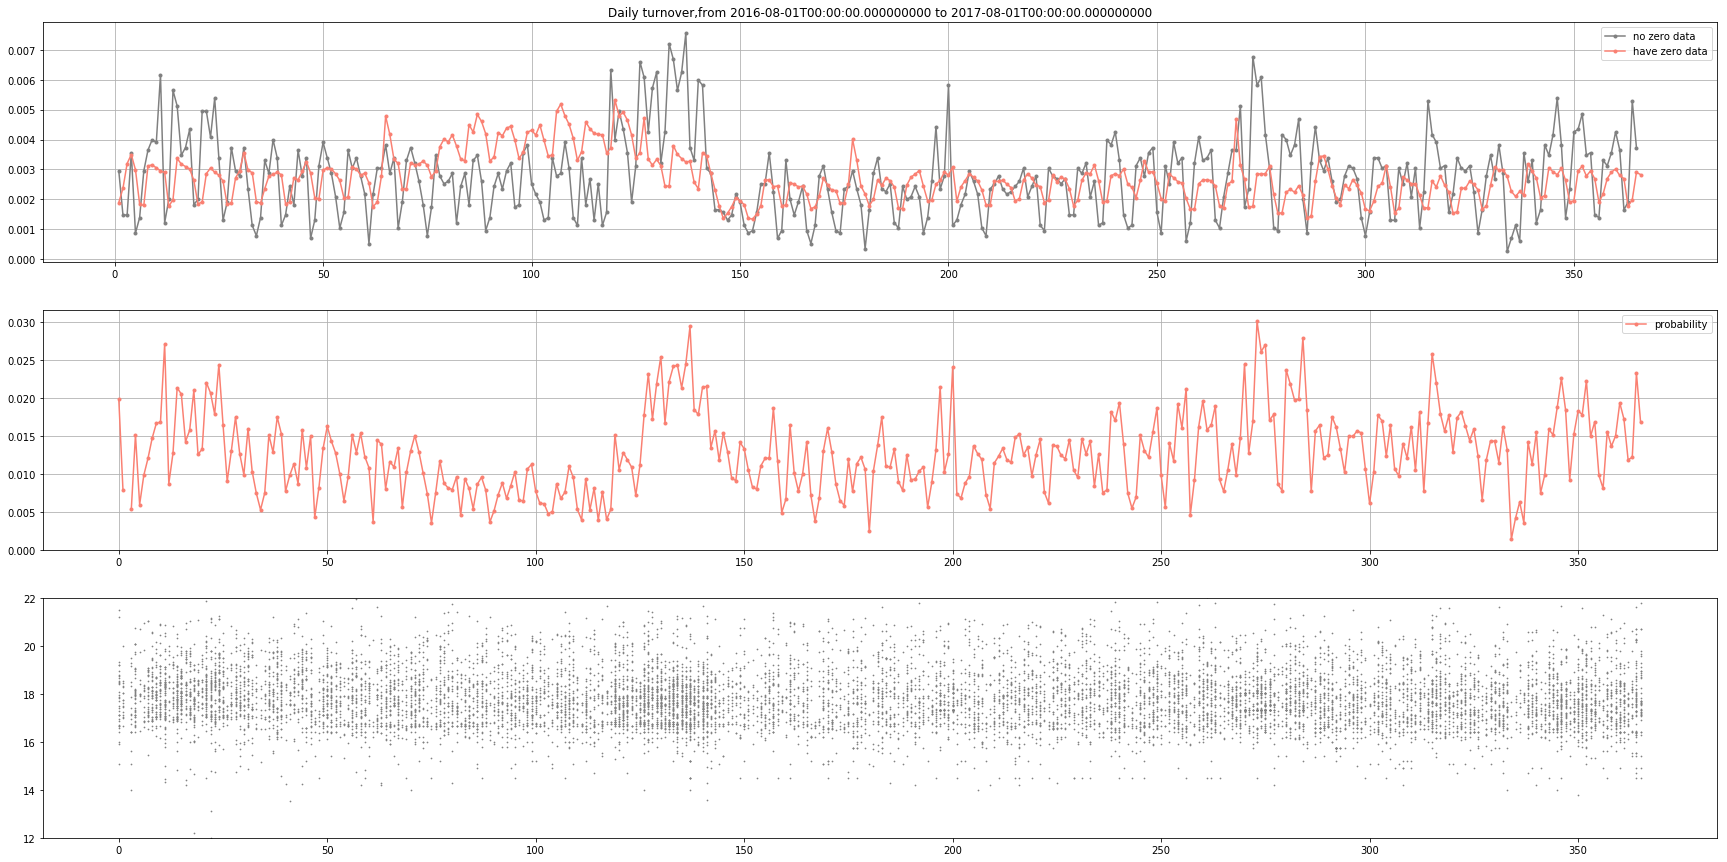

In [10]:
train['date'] = pd.to_datetime(train.date,format='%Y%m%d')


def plotdate():
    idx = train.totals_transactionRevenue.notnull()
    datetime1 = train[idx].date.value_counts(normalize=True).sort_index()
    datetime2 = train.date.value_counts(normalize=True).sort_index()
    
    date1 =  train[idx].date.value_counts().sort_index()
    date2 = train.date.value_counts().sort_index()
    
    tofirst = np.array([i.days for i in train[idx].date-datetime1.index.values[0]])
    plt.figure(figsize=[30,15])
    plt.subplot(3,1,1)
    plt.title(f'Daily turnover,from {datetime1.index.values[0]} to {datetime1.index.values[-1]}')
    plt.plot(np.arange(datetime1.shape[0])+1,
             datetime1.values,
             '.-',
             c='gray',
             label='no zero data')
    plt.plot(np.arange(datetime2.shape[0])+1,
             datetime2.values,
             '.-',
             c='salmon',label='have zero data')
    plt.grid()
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.plot(np.arange(date2.shape[0]),
             (date1/date2).values,
             '.-',
             c='salmon',
             label='probability')
    plt.grid()
    plt.legend()
    
    plt.subplot(3,1,3)
    plt.scatter(tofirst,np.log1p(train[idx].totals_transactionRevenue+1),s=0.5,alpha=1,c='gray')
    plt.ylim([12,22])
    plt.show()
    return None


plotdate()

从这个图我们可以看出一些特别有趣的现象，首先浏览量是以一周为周期变化的，所以我们应该创建一个UTC星期特征。但是，由下图可知，时间与金额无关。

In [11]:
train['week'] = train.date.apply(lambda t: t.dayofweek)

我们创建一个新的特征 holiday，可以标记处是否处于感恩节以及圣诞节假期

In [52]:
pd.Timestamp('2016-12-25')-pd.Timestamp('2016-8-1')

Timedelta('146 days 00:00:00')

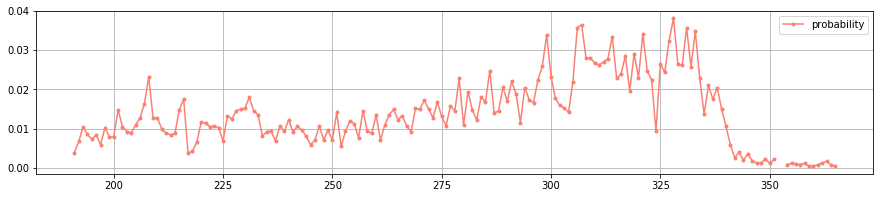

In [13]:
idx = train.trafficSource_adContent == 'Google Merchandise Collection'

date1 =  train[idx].date.value_counts().sort_index()
date2 = train.date.value_counts().sort_index()
plt.figure(figsize=[15,3])
plt.plot(np.arange(date2.shape[0]),
         (date1/date2).values,
         '.-',
         c='salmon',
         label='probability')
plt.grid()
plt.legend()


题外话：这个图解释了广告是怎么影响销售量的，在第200天左右投放的一条脍炙人口的广告，与销售量几乎同时上涨。所以我们可以创建一个新的特征，googAD，这个特征指的是一个很火的广告存在的时期。

In [14]:
idx = train.trafficSource_adContent == 'Google Merchandise Collection'
holi = train[idx].date.apply(lambda t: t.dayofyear).values
train['goodAD'] = train.date.apply(lambda t: t.dayofyear in holi)

### socialEngagementType

In [15]:
idx = (train.socialEngagementType != 'Not Socially Engaged')
sum(idx)

0

In [16]:
train.drop(['socialEngagementType'], axis=1, inplace=True)

In [17]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,...,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,target,week,goodAD
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,...,(not set),NaN,NaN,(not provided),organic,NaN,google,0.0,4,False
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,...,(not set),NaN,NaN,(not provided),organic,NaN,google,0.0,4,False
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,...,(not set),NaN,NaN,(not provided),organic,NaN,google,0.0,4,False
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,...,(not set),NaN,NaN,google + online,organic,NaN,google,0.0,4,False
4,Organic Search,2016-09-02,27294437909732085,1472822600,2,1472822600,Chrome,not available in demo dataset,not available in demo dataset,mobile,...,(not set),NaN,True,(not provided),organic,NaN,google,0.0,4,False


### visitNumber

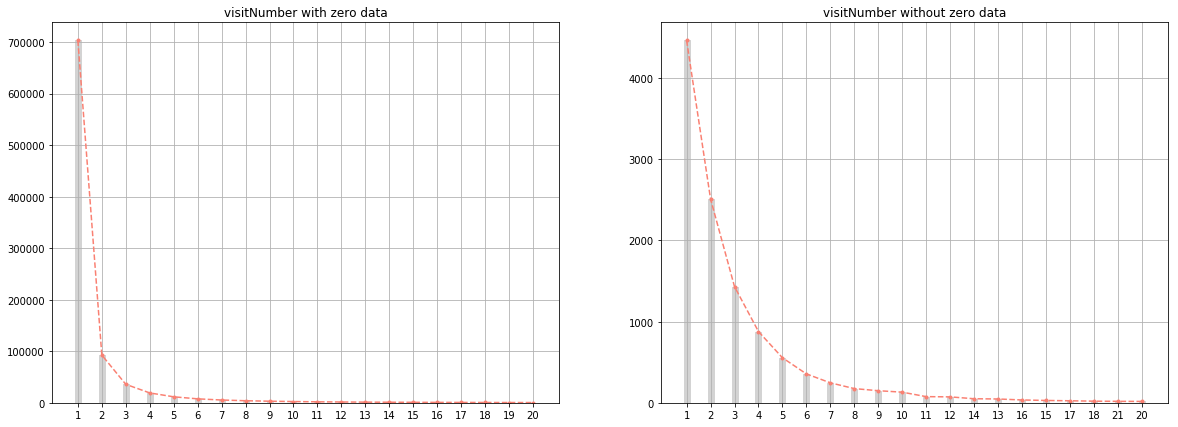

In [18]:
def plotvisitnumber():
    idx = (train.totals_transactionRevenue.notnull())
    vn1 = train.visitNumber.value_counts(dropna=False)[0:20]
    vn2 = train[idx].visitNumber.value_counts(dropna=False)[0:20]
    plt.figure(figsize=[20,7])
    plt.subplot(1,2,1)
    plt.bar(np.arange(vn1.shape[0])+1,
            vn1.values,
            facecolor='lightgray',
            width=np.ones(20)*0.25,
            edgecolor='lightgray',
            tick_label=vn1.index.values)
    plt.plot(np.arange(vn1.shape[0])+1,
             vn1.values,'.--', 
             c='salmon')
    plt.title('visitNumber with zero data')
    plt.grid()
    plt.subplot(1,2,2)
    plt.bar(np.arange(vn2.shape[0])+1,
            vn2.values,
            facecolor='lightgray',
            width=np.ones(20)*0.25,
            edgecolor='lightgray',
            tick_label=vn2.index.values)
    plt.plot(np.arange(vn2.shape[0])+1,
             vn2.values,'.--', 
             c='salmon')
    plt.title('visitNumber without zero data')
    plt.grid()
    plt.show()
    return None


plotvisitnumber()

(0, 50)

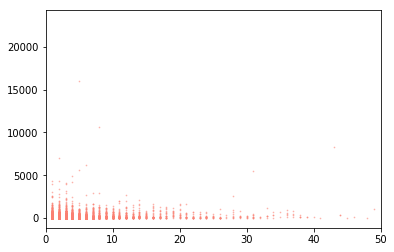

In [19]:
plt.scatter(train.visitNumber,train.totals_transactionRevenue/10**(6),s=0.5,alpha=0.5,c='salmon')
plt.xlim([0,50])

我们可以看到，visitNumber及其不平衡，大多数为1，由kaggle官方提供的说明，If this is the first session, then this is set to 1，所以大多数都是用户初次访问,但是对于成交的浏览来说，曲线更平缓一些。但是成交金额与浏览次数没有线性关系

### visitStartTime
The timestamp (expressed as POSIX time)， so we convert it to a pd.datatime

In [20]:
def totime(t):
    year = time.localtime(t)[0]
    month = time.localtime(t)[1]
    day = time.localtime(t)[2]
    hour = time.localtime(t)[3]
    minute = time.localtime(t)[4]
    second = time.localtime(t)[5]
    return pd.Timestamp(year,month,day,hour,minute,second)


train['visitStartTime'] = train.visitStartTime.map(totime)

这个features, 因为使用的是UTC，所以在时间上面有一定偏移，在之后的工作中，如果我们能否通过所在地区找到其时区，便能探索具体时间对于结果的影响。

### 去掉重复features

In [21]:
for i in train.columns:
    if sum(train[i] == train[i][0]) == train.shape[0]:
        train.drop([i], axis=1, inplace=True)
print(f'After drop feature Number is: {train.shape[1]}')

After drop feature Number is: 38


### device

In [22]:
train.iloc[:,6:10].head()

,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem
0,Chrome,desktop,False,Windows
1,Firefox,desktop,False,Macintosh
2,Chrome,desktop,False,Windows
3,UC Browser,desktop,False,Linux
4,Chrome,mobile,True,Android


In [23]:
# 我们去掉device_isMobile
train.drop(['device_isMobile'], axis=1, inplace=True)

我们可以看到device_operatingSystem 有较多(not set)项目 

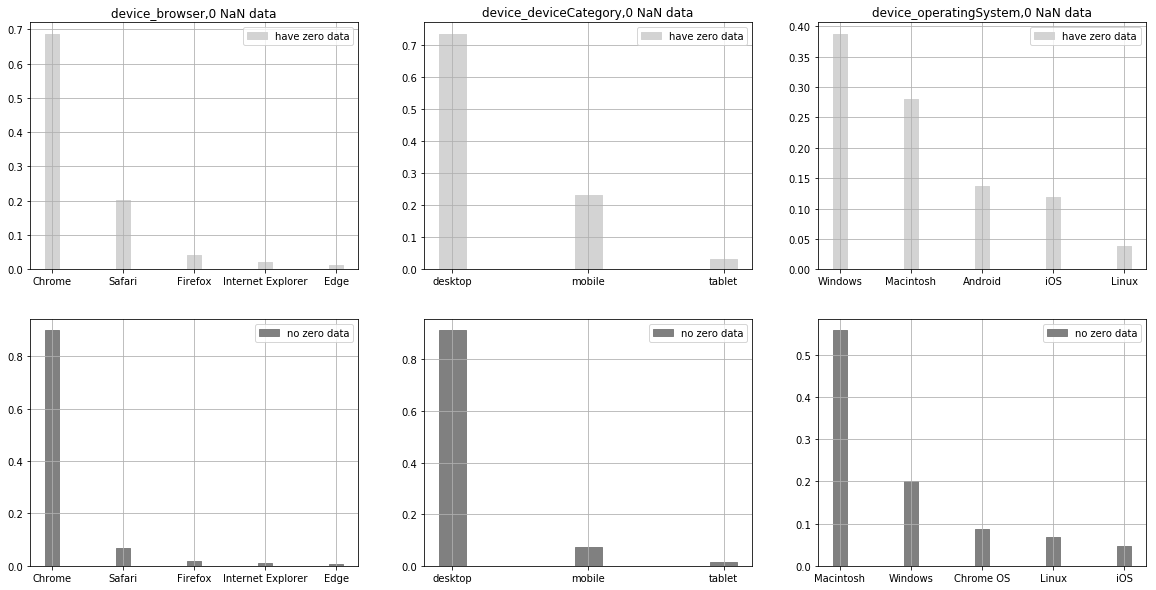

In [57]:
def plotdevice(df,top=10):
    n = 1
    plt.figure(figsize=[20,10])
    for i in df.columns[6:9]:
        idx = train.totals_transactionRevenue.notnull()
        value_count1 = train[i].value_counts(dropna=True,normalize=True)[0:top]
        value_count2 = train[idx][i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(2,3,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},{sum(train[i].isnull())} NaN data')
        plt.grid()
        plt.subplot(2,3,n+3)
        plt.grid()
        plt.bar(np.arange(value_count2.shape[0])+1.2,
                value_count2.values,           
                width=np.ones(value_count2.shape[0])*0.2,
                facecolor='gray',
                edgecolor='gray',
                tick_label=value_count2.index.values,
                label='no zero data')
        plt.legend()
        n = n+1
    plt.show()
    return None


plotdevice(train,top=5)

In [74]:
idx = train.device_browser.value_counts().index[10:-1].values
train.device_browser.replace(idx,'other').value_counts()

Chrome                  620364
Safari                  182245
Firefox                  37069
Internet Explorer        19375
Edge                     10205
Android Webview           7865
Safari (in-app)           6850
Opera Mini                6139
Opera                     5643
other                     5470
UC Browser                2427
IE with Chrome Frame         1
Name: device_browser, dtype: int64

In [66]:
train.device_browser.unique()

array(['Chrome', 'Firefox', 'UC Browser', 'Internet Explorer', 'Safari',
       'Edge', 'Opera Mini', 'Opera', 'BlackBerry', 'Safari (in-app)',
       'Coc Coc', 'Mozilla Compatible Agent', 'ADM', 'MRCHROME',
       'Amazon Silk', 'YaBrowser', 'Android Webview', 'Puffin',
       'Nokia Browser', 'Maxthon', 'Nintendo Browser', 'Android Browser',
       'Lunascape', 'IE with Chrome Frame', 'ThumbSniper',
       'LYF_LS_4002_12', 'Mozilla', 'osee2unifiedRelease', 'NokiaE52-1',
       'Iron', '[Use default User-agent string] LIVRENPOCHE', '(not set)',
       'LYF_LS_4002_11', 'M5', 'Android Runtime', 'Apple-iPhone7C2',
       'SeaMonkey', 'Konqueror', 'Seznam', 'Changa 99695759', 'no-ua',
       'MQQBrowser', 'Nichrome', 'HTC802t_TD', 'DASH_JR_3G', 'DoCoMo',
       'subjectAgent: NoticiasBoom', 'YE', 'User Agent', '0',
       'Hisense M20-M_LTE', 'Reddit', 'TCL P500M', 'CSM Click'],
      dtype=object)

我们可以看到，虽然chrome浏览器拥有较高的市场占有率，但是chrome用户也拥有更高的购买热情，可能都是google的死忠？ps:I use firefox.: )   
以及大家用桌面机的时候更倾向于交易，可能是交易需要信用卡等等信息，比较麻烦，或者单纯因为app做的不好？有趣的是mac用户拥有更高的交易意愿，可能是因为Mac比较贵？


### geoNetwork

In [25]:
train.iloc[:,9:16].head()

,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent
0,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia
1,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia
2,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe
3,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia
4,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe


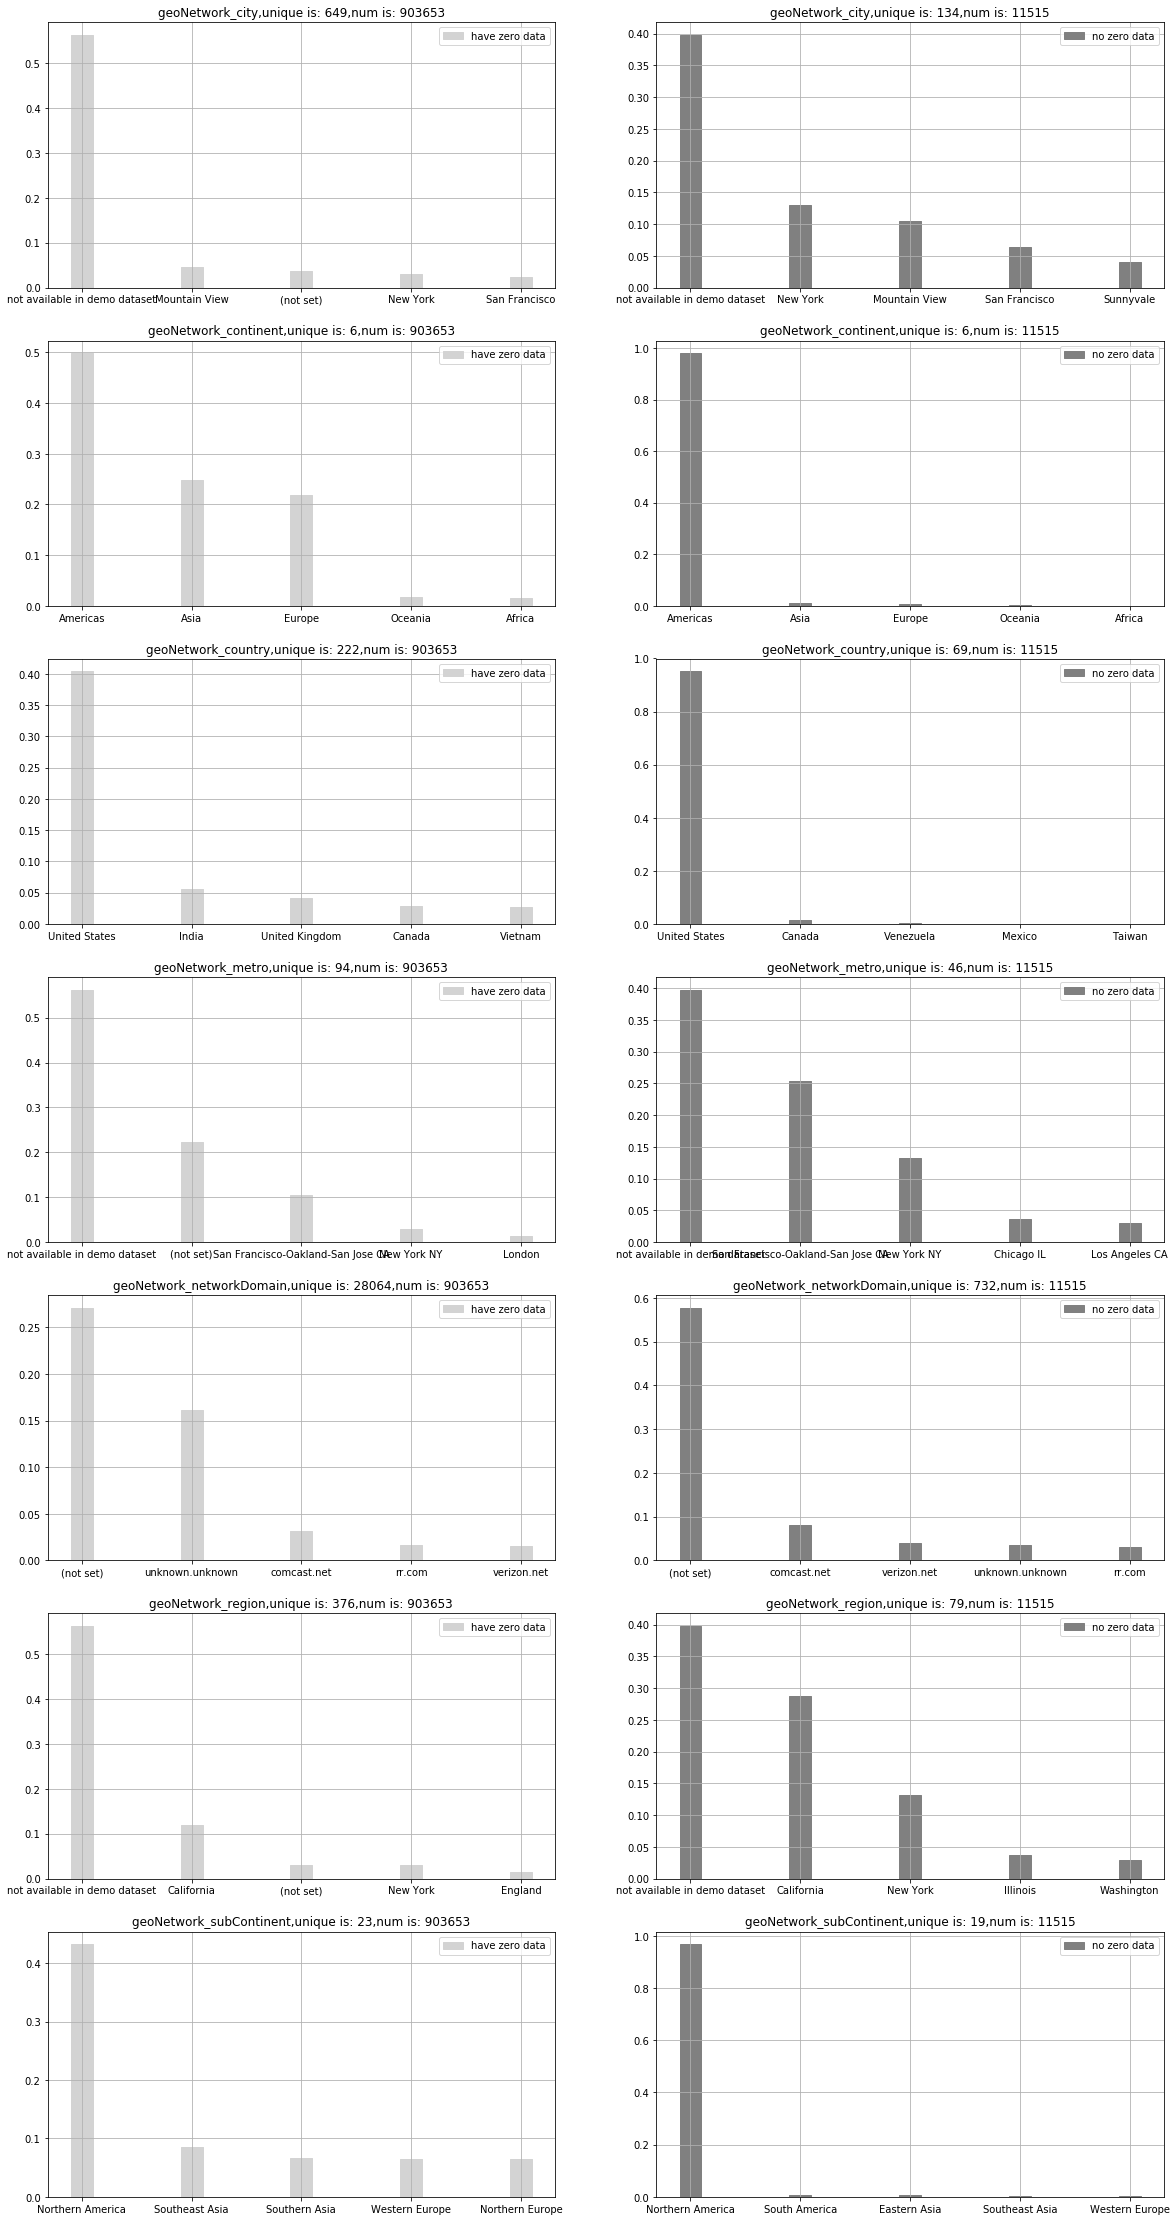

In [26]:
def plotgeonetwork(df,top=10):
    n = 1
    plt.figure(figsize=[20,40])
    for i in df.columns[9:16]:
        idx = df.totals_transactionRevenue.notnull()
        value_count1 = df[i].value_counts(dropna=True,normalize=True)[0:top]
        value_count2 = df[idx][i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(7,2,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},unique is: {df[i].nunique()},num is: {sum(df[i].notnull())}')
        plt.grid()
        plt.subplot(7,2,n+1)
        plt.grid()
        plt.bar(np.arange(value_count2.shape[0])+1.2,
                value_count2.values,           
                width=np.ones(value_count2.shape[0])*0.2,
                facecolor='gray',
                edgecolor='gray',
                tick_label=value_count2.index.values,
                label='no zero data')
        plt.title(f'{i},unique is: {df[idx][i].nunique()},num is: {sum(df[idx][i].notnull())}')
        plt.legend()
        n = n+2
    plt.show()
    return None


plotgeonetwork(train,top=5)

我们似乎可以看到，尽管全球都有浏览量，但是貌似绝大多数都是美国人在购买，并且这几个features都存在大量诸如not set，not available in demo dataset 之类的变量，之后我们要看看造成这种现象的原因。 

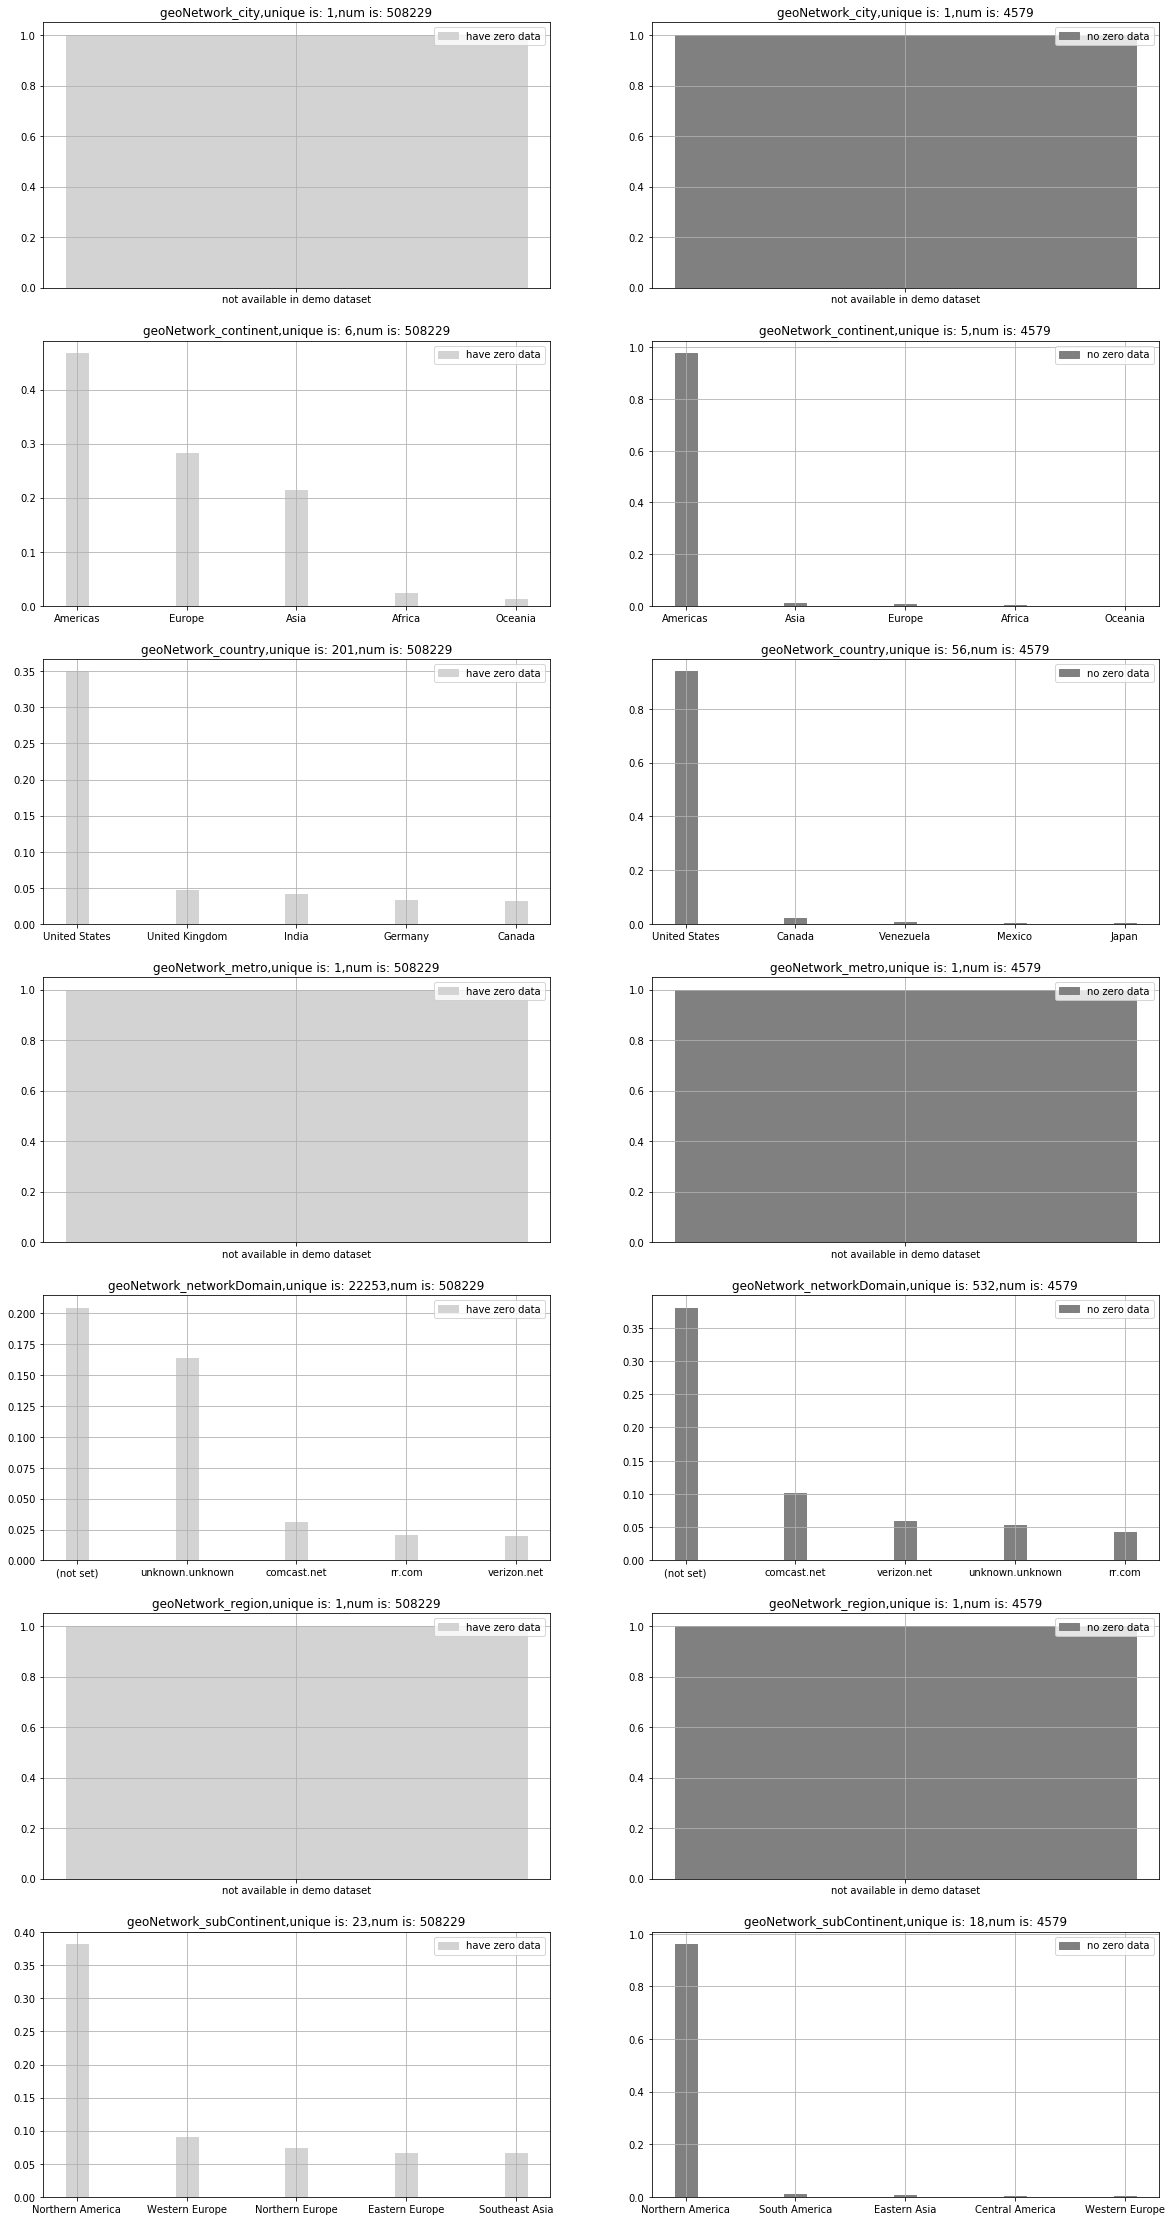

In [28]:
index =  train.geoNetwork_city == 'not available in demo dataset'
plotgeonetwork(train[index],top=5)

啊哈，一个有趣的发现，那就是city中的的not available in demo dataset其实是在city，metro,region都是not available in demo dataset的。而在其他几项中并没有明显不同

In [29]:
train['is not available'] = train.geoNetwork_city == 'not available in demo dataset'

In [30]:
idx = train['is not available'] == True
idx2 = train.totals_transactionRevenue.notnull()
print(sum(idx),sum(idx & idx2))

508229 4579


创建一个特征 domain，这个特征是由于 geoNetwork_networkDomain 中的  'unknown.unknown' 在正反例中波动过大，所以针对是否是 'unknown.unknown' ，是否是(not set) 设立成一个特征。然后就可以删除掉 geoNetwork_networkDomain.     
创建特征 notsetcity 与 notsetmetro ，因为这两个特征为 True 时，大概率属于亚洲地区，购买的意愿会大幅度降低，可能是因为运费或者价格太贵。
创建特征 isUS ，当国家为 US 时为True。

### 建议：
删除掉'geoNetwork_city'，'geoNetwork_region'，'geoNetwork_metro'，'geoNetwork_country'

### totals

In [31]:
train.iloc[:,16:20].head()

,totals_bounces,totals_hits,totals_newVisits,totals_pageviews
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,NaN,1


In [33]:
train['totals_bounces'] = train.totals_bounces.fillna(0)
train['totals_newVisits'] = train.totals_newVisits.fillna(0)


In [34]:
train.iloc[:,16:20].head()

,totals_bounces,totals_hits,totals_newVisits,totals_pageviews
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,0,1


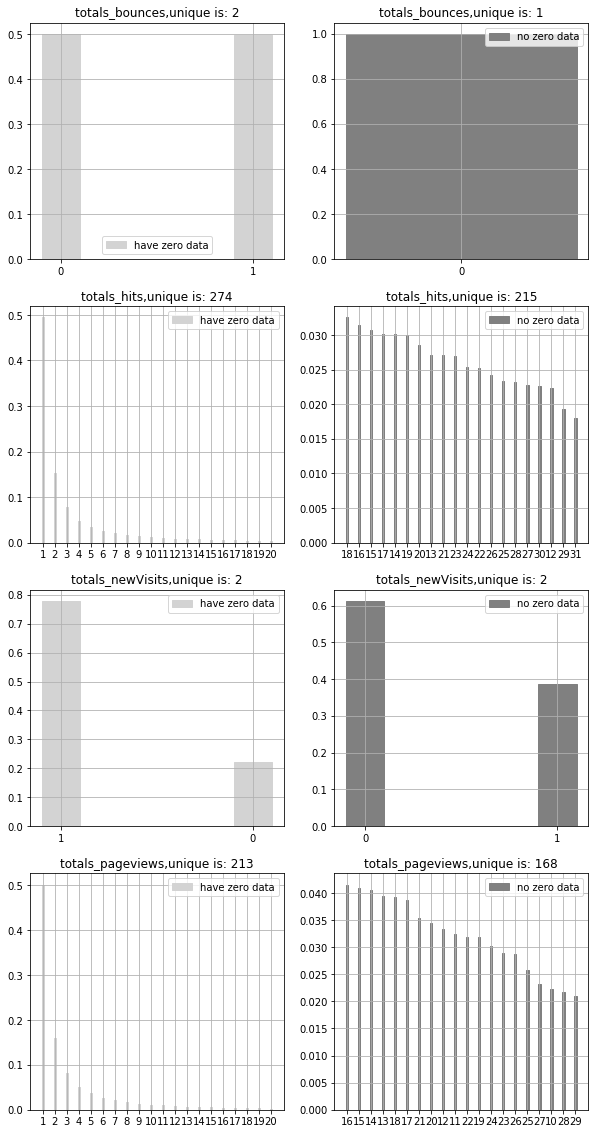

In [35]:
def plottotals(df,top=5):
    n = 1
    plt.figure(figsize=[10,20])
    for i in df.columns[16:20]:
        idx = df.totals_transactionRevenue.notnull()
        value_count1 = df[i].value_counts(dropna=True,normalize=True)[0:top]
        value_count2 = df[idx][i].value_counts(dropna=True,normalize=True)[0:top]
        plt.subplot(4,2,n)
        plt.bar(np.arange(value_count1.shape[0])+1,
                value_count1.values,           
                width=np.ones(value_count1.shape[0])*0.2,
                facecolor='lightgray',
                edgecolor='lightgray',
                tick_label=value_count1.index.values,
                label='have zero data')
        plt.legend()
        plt.title(f'{i},unique is: {df[i].nunique()}')
        plt.grid()
        plt.subplot(4,2,n+1)
        plt.grid()
        plt.bar(np.arange(value_count2.shape[0])+1.2,
                value_count2.values,           
                width=np.ones(value_count2.shape[0])*0.2,
                facecolor='gray',
                edgecolor='gray',
                tick_label=value_count2.index.values,
                label='no zero data')
        plt.title(f'{i},unique is: {df[idx][i].nunique()}')
        plt.legend()
        n = n+2
    plt.show()
    return None


plottotals(train,top=20)

emmmm~,一个了不起的发现，最终预测结果是否为0与totals_bounces相关，如果bounces=1则交易必然失败，但如果为0，也不一定成功。并且如果点击量与网页浏览量在10到30之间，则很有可能交易成功，并且我们还可以看到，老顾客购物意愿比从其他途径来的新客户更强烈。

In [36]:
train['totals_bounces'] = train.totals_bounces.astype('float')
train['totals_hits'] = train.totals_hits.astype('float')
train['totals_newVisits'] = train.totals_newVisits.astype('float')
train['totals_pageviews'] = train.totals_pageviews.astype('float')

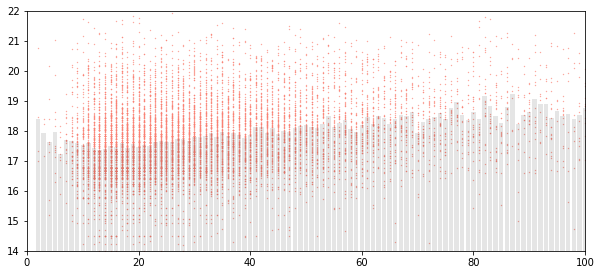

In [37]:
def scattertotals(df):
    idx = df.totals_transactionRevenue.notnull()
    df['totals_hits'] = df.totals_hits.astype('float')
    hits = df[idx].groupby('totals_hits').mean().target
    newvisit = df[idx].groupby('totals_newVisits').mean().target
    pageviews = df[idx].groupby('totals_pageviews').mean().target
    
    plt.figure(figsize=[10,15])
    plt.subplot(3,1,1)
    plt.bar(hits.index.values,hits.values,alpha=0.1,facecolor='k')
    plt.scatter(df.totals_hits.values,df.target.values,s=0.1,c='salmon')
    plt.ylim([14,22])
    plt.xlim([0,100])
    return None

scattertotals(train)

### trafficSource

In [38]:
train.iloc[:,21:34].head()

,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [ ]:
train.drop(['trafficSource_campaignCode'],axis=1,inplace=True)

## 探索Nan的分布

In [40]:
col2 = ['trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_isTrueDirect', 
        'trafficSource_keyword',
        'trafficSource_referralPath']

col = ['adContent',
       'adNetworkType',
       'gclId',
       'isTrueDirect', 
       'keyword',
       'referralPath']

num = []
for i in col2:
    for j in col2:
        idx = train[i].notnull() & train[j].notnull()
        num.append(sum(idx))
data = np.array(num).reshape(6,6)

df = pd.DataFrame(data=data,columns=col,index=col)
df

,adContent,adNetworkType,gclId,isTrueDirect,keyword,referralPath
adContent,10946,7216,7216,2397,10935,0
adNetworkType,7216,21460,21460,3756,21460,0
gclId,7216,21460,21561,3770,21460,0
isTrueDirect,2397,3756,3770,274005,72215,53487
keyword,10935,21460,21460,72215,400724,0
referralPath,0,0,0,53487,0,330941


### 结论：我对上述几项进行了两两对比，并且与channelgroup等项进行了对比，发现：      
1. referralPath项，只有当medium为referral时，才有值      
2. campaignCode：11251kjhkvahf    
3. adContent项是google广告中出现的词，将近一半与ClickInfo类，campaign，gclId有交集，但是是哪一半？啊，我们找到了一些，如果广告词中出现了'google'那么这两项的值就是共同存在的      
4. Clickinfo 类与campaign，gclId的值域基本重合，并且每一个都有关键词   
5. gclId项是google 点击 ID.   
6. 如果您服务器上的网址重写引擎更改了自动标记 gclid 值的大小写，如将 gclid=TeSter 改写为全部小写的 gclid=tester，则 Google Analytics（分析）会无法确定哪次 Google Ads 点击与哪个会话相关。如果存在任何 gclid 参数，那么系统会将数据来源识别为 source=google 和 medium=cpc，但所有其他特定于点击的数据（例如广告系列、广告组、关键字等）将在 Google Analytics（分析）报告中显示为 (not set)。   
7. gclid 与 channelGroup 中的Paid Search 高度重合，所有data如果存在gclid 那么必然来源于 付费搜索，这也就解释了为什么referralPath不与其他项相交，因为referralPath 必然来源于 referral和social。

## 探索train.trafficSource值之间的关系

In [41]:
train.columns[21:33]

Index(['trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source'],
      dtype='object')

In [42]:
idx1 = train.channelGrouping != 'Direct'
idx2 =  train.trafficSource_isTrueDirect.notnull()
idx = idx1 & idx2
print(sum(idx),sum(idx1),sum(idx2),sum(train.channelGrouping=='Referral'))
print(train.channelGrouping.value_counts())
print(train.trafficSource_medium.value_counts())

130981 760627 274005 104838
Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64
organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: trafficSource_medium, dtype: int64


In [43]:
idx = train.trafficSource_isTrueDirect.notnull()
train[idx].channelGrouping.value_counts()

Direct            143024
Organic Search     68134
Referral           40356
Social             13132
Paid Search         4789
Affiliates          2937
Display             1615
(Other)               18
Name: channelGrouping, dtype: int64

### 结论：
1. medium项与channelgroup高度重合，只是medium中的referral在Organic Search中被拆分成了Social与Direct，所以建议删除trafficSource_medium
2. 可以删除trafficSource_adwordsClickInfo.isVideoAd，因为没有意义
3. 可以删除trafficSource_adwordsClickInfo.adNetworkType，没啥意义
4. 可以删除trafficSource_adwordsClickInfo.page 和 trafficSource_adwordsClickInfo.slot ，也没啥意义
5. 建议删除trafficSource_keyword，trafficSource_campaign，还是没啥意义

### 所以我们剩下什么了？
1. 'trafficSource_adContent'：只有cahnnelgrouping 为Paid Search时才有值，并且出项google时便会拥有一个gclid   
2. 'trafficSource_adwordsClickInfo.gclId'：我还没想出怎么去利用这一串乱码，并且只有cahnnelgrouping 为Paid Search时才有值，并且一个fullVisitorId只对应一个gclid,其实吧，可以吧是否存在gclid作为一个feature，然后把这个删掉。。。
#### important! 
3. 'trafficSource_isTrueDirect'：如果会话的来源是“Direct”（表示用户在浏览器中输入了您网站网址的名称或是通过书签访问了您的网站），则为 True；如果 2 个连续但不同的会话具有完全相同的广告系列详细信息，则此字段也为 true。否则为 NULL。所以，我们可以把这两种情况区分开。
4. 'trafficSource_referralPath' ：如果 trafficSource.medium 为“referral”，则此值为引荐来源网址的路径。（引荐来源网址的主机名包含在 trafficSource.source 中。）只有cahnnelgrouping 为 referral 和 Social 的这一项才有值，我们似乎可以从这里也找到一些出国别之类或者习惯之类的信息。  
5. 'trafficSource_source'：流量来源的来源。可以是搜索引擎的名称、引荐来源网址的主机名或 utm_source 网址参数的一个值。

In [44]:
idx = (train.trafficSource_isTrueDirect.notnull()) & (train.channelGrouping != 'Direct') 
idx2 = train.totals_transactionRevenue.notnull()
print(train[idx].channelGrouping.value_counts())
print(sum(idx),sum(idx & idx2))

Organic Search    68134
Referral          40356
Social            13132
Paid Search        4789
Affiliates         2937
Display            1615
(Other)              18
Name: channelGrouping, dtype: int64
130981 4962


### 新的特征：
我们现在可以创建一个新的特征，当istrueDirect不为空，channelgrouping不为direct，totoals_bounces为0，创建新特征 isTrueDirect ，这个特征貌似有非常好的效果。
并且，我们可以把trafficSource_source 和 trafficSource_referralPath 拼接起来。组成一个新的特征 path。

In [45]:
train['path'] = train.trafficSource_source +  train.trafficSource_referralPath.fillna('') 

In [46]:
idx = train.totals_transactionRevenue.notnull()

for i in train.columns[21:33]:
    print('\n',
          train[i].value_counts(),
          '\n',
          'len is: ', train[i].value_counts().shape[0],
          'Num is: ',sum(train[i].notnull()),
          'Nan is: ',sum(train[i].isnull()),
          '\n',
          '-'*80,
          '\n',
          train[idx][i].value_counts(),      
          '\n',
          'len is: ',train[idx][i].value_counts().shape[0],
          'Num is: ',sum(train[idx][i].notnull()),
          'Nan is: ',sum(train[idx][i].isnull()),
          '\n',
          '*'*80)


 Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
First Full Auto Template Test Ad                 87
Google Merchandise                               87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:G


 False    21460
Name: trafficSource_adwordsClickInfo.isVideoAd, dtype: int64 
 len is:  1 Num is:  21460 Nan is:  882193 
 -------------------------------------------------------------------------------- 
 False    454
Name: trafficSource_adwordsClickInfo.isVideoAd, dtype: int64 
 len is:  1 Num is:  454 Nan is:  11061 
 ********************************************************************************

 1     21362
2        73
3        10
5         7
7         3
4         2
9         2
14        1
Name: trafficSource_adwordsClickInfo.page, dtype: int64 
 len is:  8 Num is:  21460 Nan is:  882193 
 -------------------------------------------------------------------------------- 
 1    454
Name: trafficSource_adwordsClickInfo.page, dtype: int64 
 len is:  1 Num is:  454 Nan is:  11061 
 ********************************************************************************

 Top    20956
RHS      504
Name: trafficSource_adwordsClickInfo.slot, dtype: int64 
 len is:  2 Num is:  21460 Nan is:  88


 /                                                                                                                                                                                  75523
/yt/about/                                                                                                                                                                         71036
/analytics/web/                                                                                                                                                                    14620
/yt/about/tr/                                                                                                                                                                      14599
/yt/about/vi/                                                                                                                                                                      13753
/yt/about/es-419/                                                        


 google                                                          400788
youtube.com                                                     212602
(direct)                                                        143028
mall.googleplex.com                                              66416
Partners                                                         16411
analytics.google.com                                             16172
dfa                                                               5686
google.com                                                        4669
m.facebook.com                                                    3365
baidu                                                             3356
sites.google.com                                                  2983
facebook.com                                                      2296
siliconvalley.about.com                                           2097
reddit.com                                                        2022
qiit

In [47]:
idx = train['trafficSource_adwordsClickInfo.slot'] == 'RHS'
train[idx].date

5361     2017-06-23
10921    2016-08-11
10930    2016-08-11
12195    2016-08-11
14953    2017-06-13
15057    2017-06-13
15295    2017-06-13
26990    2016-11-12
27056    2016-11-12
27087    2016-11-12
27155    2016-11-12
27162    2016-11-12
27163    2016-11-12
27176    2016-11-12
28973    2017-06-21
29250    2017-06-21
30178    2017-06-21
30706    2017-06-21
31629    2016-11-23
31822    2016-11-23
36072    2017-05-01
38402    2017-06-11
38471    2017-06-11
39269    2017-06-30
41375    2016-12-13
44763    2017-05-19
44837    2017-05-19
45994    2017-05-19
46456    2017-05-19
47480    2017-01-11
            ...    
850608   2017-06-29
851176   2017-06-29
852325   2017-06-25
852363   2017-06-25
852974   2017-06-25
853427   2017-06-25
856691   2017-05-20
861021   2016-09-18
862644   2017-02-12
863849   2017-03-26
864218   2017-03-26
868987   2017-05-12
869188   2017-05-12
869870   2017-01-07
870545   2017-01-07
874324   2016-10-05
874341   2016-10-05
876472   2016-12-17
876823   2016-12-17


In [48]:
idx = train.totals_transactionRevenue.notnull()

print(
    train.path.value_counts()[0:10],
    'Num is: ',sum(train[i].notnull()),
    '\n','*'*40,'\n',
    train[idx].path.value_counts()[0:10],
    'Num is: ',sum(train[idx][i].notnull()),
)

google                                 400788
(direct)                               143028
youtube.com/yt/about/                   71036
mall.googleplex.com/                    66416
Partners                                16411
youtube.com/yt/about/tr/                14599
analytics.google.com/analytics/web/     14535
youtube.com/yt/about/vi/                13753
youtube.com/yt/about/es-419/            12735
youtube.com/yt/about/pt-BR/             12003
Name: path, dtype: int64 Num is:  903653 
 **************************************** 
 mall.googleplex.com/                      5103
google                                    3879
(direct)                                  2042
dfa                                        123
mail.google.com/mail/u/0/                   55
groups.google.com/a/google.com/forum/       35
yahoo                                       22
dealspotr.com/google-merchandise-store      22
bing                                        21
gdeals.googleplex.com/offer/214

### 建议：
去掉 trafficSource_source 和 trafficSource_referralPath 